# Congressional Speech Analysis

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.display.max_columns = 1200  
pd.options.display.max_rows = 1200 

import unicodedata
import itertools
import datetime
import datefinder
import operator
import string
import re

import nltk
from nltk.tokenize import sent_tokenize

def listdir_nohidden(path):
    return glob.glob(os.path.join(path, '*'))

### Get speeches

In [2]:
path = '/Users/yc00027/Documents/GitHub/congress_speech_analysis/speeches_df.csv'
speeches_df = pd.read_csv(path).reset_index().rename(columns={'index': 'unique_sentence_id'})
speeches_df.drop(columns=['speech'], inplace=True)

print(f'Speeches DF shape: {speeches_df.shape}')
speeches_df.head()

/Users/yc00027/py3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Speeches DF shape: (2843773, 17)


,unique_sentence_id,document_id,sentence,sentence_id,speech_id,unique_speech_id,clean_speaker_name,prefix,document_title,hearing_date,chairman,speech_len,congress,office,department,name,sentence_len
0,0,1837,the subcommittees will come to order.,11,10.0,309462.0,no match,ms.,eastern mediterranean energy: challenges and o...,"september 8, 2016",edward r. royce,857.0,114th,House,Ad Hoc Energy,1.txt,6
1,1,1837,"after recognizing myself, chairman weber, rank...",12,10.0,309462.0,no match,ms.,eastern mediterranean energy: challenges and o...,"september 8, 2016",edward r. royce,857.0,114th,House,Ad Hoc Energy,1.txt,31
2,2,1837,we will then hear from our witnesses.,13,10.0,309462.0,no match,ms.,eastern mediterranean energy: challenges and o...,"september 8, 2016",edward r. royce,857.0,114th,House,Ad Hoc Energy,1.txt,7
3,3,1837,"and, without \nobjection, the witnesses' prepa...",14,10.0,309462.0,no match,ms.,eastern mediterranean energy: challenges and o...,"september 8, 2016",edward r. royce,857.0,114th,House,Ad Hoc Energy,1.txt,35
4,4,1837,we are also expected to be joined by the chair...,15,10.0,309462.0,no match,ms.,eastern mediterranean energy: challenges and o...,"september 8, 2016",edward r. royce,857.0,114th,House,Ad Hoc Energy,1.txt,36


In [3]:
bills93_114_df = pd.read_csv('bills93-114.csv', error_bad_lines=False, encoding='ISO-8859-1', sep = ';')
bills_114 = bills93_114_df[bills93_114_df['Cong'] == 114]
bills_114 = bills_114[bills_114['BillType'].isin(['hr', 's'])]

print(f'There were {bills_114.shape[0]} bills in Congress 114th.')

speaker_names = sorted(bills_114['NameFull'].str.lower().unique())
print(f'There were {len(speaker_names)} speakers in Congress 114th.')
print('')

print('Number of bills according to bill type:')
print(bills_114['BillType'].value_counts())
print('')

print('Bill types: "hr" (House Bill); "s" (Senate Bill); "hres" (House Resolution); "sres" (Senate Resolution); \
                   "hcon" (House Concurrent Resolution); "scon" (Senate Concurrent Resolution); \
                   "hjres" (House Joint Resolution); "sjres" (Senate Joint Resolution).')

bills_114.head()

There were 10055 bills in Congress 114th.
There were 542 speakers in Congress 114th.

Number of bills according to bill type:
hr    6508
s     3547
Name: BillType, dtype: int64

Bill types: "hr" (House Bill); "s" (Senate Bill); "hres" (House Resolution); "sres" (Senate Resolution);                    "hcon" (House Concurrent Resolution); "scon" (Senate Concurrent Resolution);                    "hjres" (House Joint Resolution); "sjres" (Senate Joint Resolution).


,BillID,BillNum,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,MultNo,PLaw,Private,Title,Veto,Class,ComC,ComR,CumHServ,CumSServ,Delegate,District,DW1,FrstConH,FrstConS,Gender,MemberID,MRef,NameFirst,NameFull,NameLast,Party,PooleID,Postal,State,URL,ChRef,RankRef,PassH,PassS,PLawDate,PLawNum,ImpBill,SubChRef,SubRankRef,Majority,ReportH,ReportS,Major,Minor
282772,114-HR-2,2,hr,0,114,13.0,2015-03-24,1.0,6.0,1,0,To amend title XVIII of the Social Security Ac...,0,NaN,1.0,0.0,5110.0,0.0,0,26.0,"0,565",0.0,0.0,0,20355-114-200,1,Michael,Michael Burgess,Burgess,200.0,20355.0,TX,49,https://www.congress.gov/bill/114th-congress/h...,0,0,1,1,NaN,320,1.0,0.0,0.0,1,0,0,3.0,323.0
282773,114-HR-3,3,hr,0,114,30.0,2015-01-06,1.0,3.0,0,0,To approve the Keystone XL Pipeline.,0,NaN,0.0,0.0,1461.0,0.0,0,0.0,"0,375",0.0,0.0,0,21350-114-200,1,Kevin,Kevin Cramer,Cramer,200.0,21350.0,ND,36,https://www.congress.gov/bill/114th-congress/h...,0,0,1,0,NaN,NaN,1.0,0.0,0.0,1,0,0,8.0,803.0
282774,114-HR-5,5,hr,0,114,11.0,2015-02-03,1.0,2.0,0,0,To support State and local accountability for ...,0,NaN,1.0,0.0,5110.0,0.0,0,2.0,"0,49",0.0,0.0,0,20333-114-200,1,John,John Kline,Kline,200.0,20333.0,MN,33,https://www.congress.gov/bill/114th-congress/h...,1,0,1,0,NaN,NaN,1.0,0.0,0.0,1,1,0,6.0,602.0
282775,114-HR-6,6,hr,0,114,230.0,2015-05-19,1.0,3.0,0,0,"To accelerate the discovery, development, and ...",0,NaN,1.0,0.0,10955.0,0.0,0,6.0,"0,337",0.0,0.0,0,15446-114-200,1,Fred,Fred Upton,Upton,200.0,15446.0,MI,23,https://www.congress.gov/bill/114th-congress/h...,1,0,1,0,NaN,NaN,1.0,0.0,0.0,1,1,0,3.0,398.0
282776,114-HR-7,7,hr,0,114,29.0,2015-01-21,1.0,4.0,0,0,To prohibit taxpayer funded abortions.,0,NaN,1.0,0.0,13147.0,0.0,0,4.0,"0,156",0.0,0.0,0,14863-114-200,0,Christopher,Christopher Smith,Smith,200.0,14863.0,NJ,12,https://www.congress.gov/bill/114th-congress/h...,0,0,1,0,NaN,NaN,1.0,0.0,0.0,1,0,0,2.0,208.0


### Get bills

In [4]:
characters = ["-", "...", "''", "``", "@", "#",  
              '--', '=', '_', '..', '|', "/",
              '~', '—', '•', '“', '–', '>', '*']

def clean_text(text):
    '''Remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = text.replace(' \n', ' ')
    for character in characters:
        text = text.replace(character, " ")
    text = ' '.join(text.split())
    return text

In [5]:
bills_1 = []
sentences = [sentence for sentence in speeches_df['sentence']]

for i, sentence in enumerate(sentences):
    if 'h.r.' in sentence:
        try:
            if sentence.split('h.r. ')[1].split(' ')[0].isdigit():
                bills_1.append({'sentence_id': i,
                              'bill_id': sentence.split('h.r. ')[1].split(' ')[0],
                              'bill_type': 'hr',
                              'sentence': sentence
                              })
        except IndexError:
            i_plus = 1
            sentence += sentences[i+i_plus]
            bills_1.append({'sentence_id': i,
                          'bill_id': sentences[i+i_plus].split(' ')[0],
                          'bill_type': sentences[i].split(' ')[-1],
                          'sentence': sentence
                          })
            
    elif ' s. ' in sentence:
        try:
            if sentence.split(' s. ')[1].split(' ')[0].isdigit():
                bills_1.append({'sentence_id': i,
                          'bill_id': sentence.split(' s. ')[1].split(' ')[0],
                          'bill_type': 's',
                          'sentence': sentence
                             })
        except IndexError:
            i_plus = 1
            sentence += sentences[i+i_plus]
            bills_1.append({'sentence_id': i,
                          'bill_id': sentences[i+i_plus].split(' ')[0],
                          'bill_type': sentences[i].split(' ')[-1],
                          'sentence': sentence
                          })
    else:
        continue

bills_1_df = pd.DataFrame(bills_1)
bills_1_df['sentence'] = [clean_text(sentence) for sentence in bills_1_df['sentence']]

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

repl_dict = {'),' : '', '.': '', ',': '', ';': '', ')': '', '\n': '', '(': '', '``':'', 'follows:]':'', 
            'bill--hr': 'hr', 'vahr': 'hr', 'introduced--hr': 'hr', 'education--hr': 'hr', '160/hr': 'hr', 
             'organizations--hr': 'hr', '829/hr': 'hr', 'hr?' : 'hr',  '2612/hr' : 'hr',  'bills--hr' : 'hr', 
             'me--hr' : 'hr', 'to--hr' : 'hr',  "hr''" : 'hr'}

bills_1_df['bill_id'] = bills_1_df['bill_id'].apply(lambda x: replace_all(x, repl_dict))
bills_1_df['bill_type'] = bills_1_df['bill_type'].apply(lambda x: replace_all(x, repl_dict))

bills_1_df = bills_1_df[bills_1_df['bill_id'].apply(lambda x: x.isdigit())]
bills_1_df = bills_1_df[bills_1_df['bill_type'].isin(['hr', 's'])] 

print(f'Bills DF shape: {bills_1_df.shape}')
print('Number of S. bills and number of H.R. bills:')
print('')
print(bills_1_df.bill_type.value_counts())
print('')
bills_1_df.head()

Bills DF shape: (4376, 4)
Number of S. bills and number of H.R. bills:

hr    3728
s      648
Name: bill_type, dtype: int64



,bill_id,bill_type,sentence,sentence_id
0,5094,hr,while the legislation to support military fund...,2500
1,609,hr,"james p. mcgovern, a representative in congres...",5077
2,609,hr,while usda has not fully evaluated the safe fo...,5081
3,2051,hr,"h.r.2051, mandatory price reporting act of 201...",6275
4,2088,hr,"h.r.2088, united states grain standards act re...",7406


In [6]:
bill_types = [' hr ', ' hr', ' h.r. ', ' h.r.', ' hr. ', ' hr.',
              ' hconres ', ' hconres',  ' hconres. ', ' hconres.', 
              ' hjres ', ' hjres', ' hjres. ', ' hjres.',
              ' hres ', ' hres', ' hres. ', ' hres.',
              ' s. ', ' s.', ' s_ ', ' s_', ' sb ',
              ' sconres ', ' sconres', ' sconres. ', ' sconres.',
              ' sjres ', ' sjres', ' sjres. ', ' sjres.',
              ' sres ', ' sres', ' sres. ', ' sres.']

bills = []

for index, sentence in zip(speeches_df.index, speeches_df['sentence']):
    sentence = sentence.replace(' s. ', ' sb ').replace(' h.r.', ' hr ').replace(' h.r. ', ' hr ').replace(' s.', ' sb ')
    if any(x in sentence for x in bill_types):
        try:
            regex = re.compile(r'(?: h.r. | hr | hr. |hr| hconres | hconres. | hjres | hjres. | hres | hres. | \
                                     s. | sb | sconres | sconres. | sjres | sjres. | sres | sres. )+(\d+)+')
            bills.append({'sentence_id': index,
                            'bill_id': regex.findall(sentence),
                            'bill_type': [b for b in bill_types if b in sentence],
                            'sentence': sentence
                            })
        except Exception as e:
            print(sentence)
            raise(e)  

bills_df = pd.DataFrame(bills)

bills_df = bills_df[bills_df.astype(str)['bill_id'] != "[]"]
bills_df['bill_id'] = bills_df['bill_id'].str[0]
bills_df['bill_type'] = bills_df['bill_type'].str[0]
bills_df['bill_type'] = bills_df['bill_type'].replace(" sb ", "s").replace(" s.", "s").replace(" hr ", "hr").replace(" hr", "hr")
bills_df['sentence'] = [clean_text(sentence) for sentence in bills_df['sentence']]

print(f'Bills DF shape: {bills_df.shape}')
print('Number of S. bills and number of H.R. bills:')
print('')
print(bills_df.bill_type.value_counts())
print('')
bills_df.head()

Bills DF shape: (1816, 4)
Number of S. bills and number of H.R. bills:

s     1737
hr      79
Name: bill_type, dtype: int64



,bill_id,bill_type,sentence,sentence_id
12,338,s,after the release of the first lottery match r...,16193
13,339,s,sb 384 (moolenaar) allows for the withholding ...,16195
66,2496,s,this includes a letter signed by 13 senators w...,48574
67,2613,s,"\21\ secret science reform act of 2014, sb 261...",48577
169,235,s,"167, sb 235, sb 1645), which aims to limit the...",56046


In [7]:
columns_to_drop = ['BillID', 'Chamber', 'Cong', 'Cosponsr', 'IntrDate', 
                   'Mult', 'MultNo', 'PLaw', 'Private', 'Title', 'Veto', 
                   'Class', 'ComC', 'ComR', 'CumHServ', 'CumSServ', 
                   'Delegate', 'District', 'DW1', 'FrstConH', 'FrstConS', 
                   'Gender', 'MemberID', 'MRef', 'NameFirst', 'NameFull', 
                   'NameLast', 'Party', 'PooleID', 'Postal', 'State', 
                   'URL', 'ChRef', 'RankRef', 'PLawDate','PLawNum', 
                   'ImpBill', 'SubChRef', 'SubRankRef', 'Majority', 
                   'ReportH', 'ReportS', 'Major', 'Minor']

_bills_temp_df = pd.concat([bills_df, bills_1_df]).groupby('sentence_id').first().reset_index()
_bills_temp_df['bill_id'] = _bills_temp_df['bill_id'].astype(int)
_bills_df = pd.merge(_bills_temp_df, bills_114.drop(columns=columns_to_drop), left_on=['bill_id', 'bill_type'], right_on = ['BillNum', 'BillType'], how='left')

print(f'Bills DF shape: {_bills_df.shape}')
print('Number of S. bills and number of H.R. bills:')
print('')
print(_bills_df.bill_type.value_counts())
print('')
_bills_df.head()

Bills DF shape: (5502, 8)
Number of S. bills and number of H.R. bills:

hr    3765
s     1737
Name: bill_type, dtype: int64



,sentence_id,bill_id,bill_type,sentence,BillNum,BillType,PassH,PassS
0,2500,5094,hr,while the legislation to support military fund...,5094.0,hr,1.0,0.0
1,5077,609,hr,"james p. mcgovern, a representative in congres...",609.0,hr,0.0,0.0
2,5081,609,hr,while usda has not fully evaluated the safe fo...,609.0,hr,0.0,0.0
3,6275,2051,hr,"h.r.2051, mandatory price reporting act of 201...",2051.0,hr,1.0,1.0
4,7406,2088,hr,"h.r.2088, united states grain standards act re...",2088.0,hr,1.0,0.0


In [8]:
congress_114_bills_df = pd.merge(_bills_df.drop(columns=['BillNum', 'BillType']), speeches_df.drop(columns=['sentence', 'sentence_id']), left_on='sentence_id', right_on = 'unique_sentence_id', how='left')

print(f'Full 114th Congress Bills DF shape: {congress_114_bills_df.shape}')
congress_114_bills_df.head()

Full 114th Congress Bills DF shape: (5502, 21)


,sentence_id,bill_id,bill_type,sentence,PassH,PassS,unique_sentence_id,document_id,speech_id,unique_speech_id,clean_speaker_name,prefix,document_title,hearing_date,chairman,speech_len,congress,office,department,name,sentence_len
0,2500,5094,hr,while the legislation to support military fund...,1.0,0.0,2500,1655,53.0,255376.0,no match,mr.,baltic security after the warsaw nato summit,"december 7, 2016",christopher h. smith,1702.0,114th,House,Commission on Security and Cooperation in Europe,5.txt,47
1,5077,609,hr,"james p. mcgovern, a representative in congres...",0.0,0.0,5077,1255,2308.0,177139.0,no match,secretary,hearing to review the state of the rural economy,"february 11, 2015",k. michael conaway,8376.0,114th,House,Agriculture,1.txt,23
2,5081,609,hr,while usda has not fully evaluated the safe fo...,0.0,0.0,5081,1255,2308.0,177139.0,no match,secretary,hearing to review the state of the rural economy,"february 11, 2015",k. michael conaway,8376.0,114th,House,Agriculture,1.txt,14
3,6275,2051,hr,"h.r.2051, mandatory price reporting act of 201...",1.0,1.0,6275,1220,1151.0,170128.0,no match,mr.,hearing to review reauthorization of the lives...,"april 22, 2015",k. michael conaway,160.0,114th,House,Agriculture,10.txt,9
4,7406,2088,hr,"h.r.2088, united states grain standards act re...",1.0,0.0,7406,1223,1327.0,170620.0,no match,mr.,hearing to review reauthorization of the u.s. ...,"april 22, 2015",k. michael conaway,866.0,114th,House,Agriculture,11.txt,9


### Sentiment Analysis

For a body of text, vaderSentiment provides four measures. The first measures the negativity of the text and the second measures positivity. The third measures the text’s neutrality. The last measure represents a “compound” value, aggregating and normalizing  the  former  measures.

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))
    
# getting only the negative score
def negative_score(text):
    negative_value = analyser.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyser.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyser.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyser.polarity_scores(text)['compound']
    return compound_value

In [10]:
congress_114_bills_df['sentiment_neg'] = congress_114_bills_df['sentence'].apply(negative_score)
congress_114_bills_df['sentiment_neu'] = congress_114_bills_df['sentence'].apply(neutral_score)
congress_114_bills_df['sentiment_pos'] = congress_114_bills_df['sentence'].apply(positive_score)
congress_114_bills_df['sentiment_compound'] = congress_114_bills_df['sentence'].apply(compound_score)

In [11]:
congress_114_bills_df.to_excel('congress_114_bills_df.xlsx', index=False)
print(f'Full 114th Congress Bills DF shape: {congress_114_bills_df.shape}')
congress_114_bills_df.head()

Full 114th Congress Bills DF shape: (5502, 25)


,sentence_id,bill_id,bill_type,sentence,PassH,PassS,unique_sentence_id,document_id,speech_id,unique_speech_id,clean_speaker_name,prefix,document_title,hearing_date,chairman,speech_len,congress,office,department,name,sentence_len,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,2500,5094,hr,while the legislation to support military fund...,1.0,0.0,2500,1655,53.0,255376.0,no match,mr.,baltic security after the warsaw nato summit,"december 7, 2016",christopher h. smith,1702.0,114th,House,Commission on Security and Cooperation in Europe,5.txt,47,0.0,0.828,0.172,0.8689
1,5077,609,hr,"james p. mcgovern, a representative in congres...",0.0,0.0,5077,1255,2308.0,177139.0,no match,secretary,hearing to review the state of the rural economy,"february 11, 2015",k. michael conaway,8376.0,114th,House,Agriculture,1.txt,23,0.0,0.853,0.147,0.6908
2,5081,609,hr,while usda has not fully evaluated the safe fo...,0.0,0.0,5081,1255,2308.0,177139.0,no match,secretary,hearing to review the state of the rural economy,"february 11, 2015",k. michael conaway,8376.0,114th,House,Agriculture,1.txt,14,0.0,0.779,0.221,0.7152
3,6275,2051,hr,"h.r.2051, mandatory price reporting act of 201...",1.0,1.0,6275,1220,1151.0,170128.0,no match,mr.,hearing to review reauthorization of the lives...,"april 22, 2015",k. michael conaway,160.0,114th,House,Agriculture,10.txt,9,0.0,0.874,0.126,0.0772
4,7406,2088,hr,"h.r.2088, united states grain standards act re...",1.0,0.0,7406,1223,1327.0,170620.0,no match,mr.,hearing to review reauthorization of the u.s. ...,"april 22, 2015",k. michael conaway,866.0,114th,House,Agriculture,11.txt,9,0.0,0.811,0.189,0.4215


In [12]:
congress_114_bills_df.groupby('PassH')['sentiment_compound'].mean()

PassH
0.0    0.374681
1.0    0.342423
Name: sentiment_compound, dtype: float64

In [13]:
congress_114_bills_df.groupby('PassS')['sentiment_compound'].mean()

PassS
0.0    0.364207
1.0    0.378905
Name: sentiment_compound, dtype: float64

([<matplotlib.axis.YTick at 0x133d599d0>,
 <a list of 6 Text yticklabel objects>)

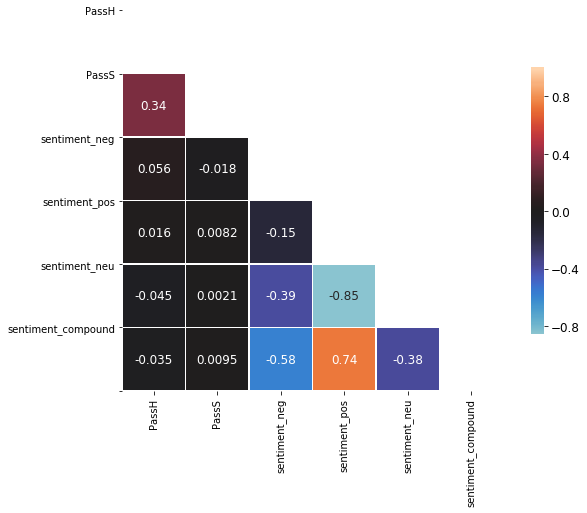

In [14]:
df = congress_114_bills_df[['PassH', 'PassS', 'sentiment_neg', 'sentiment_pos', 'sentiment_neu', 'sentiment_compound']]
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(10, 7))
plt.rc('font', size=12)  

sns.heatmap(corr, mask=mask, center=0, linewidths=.5, square=True, annot=True, cbar_kws={"shrink": .7})
plt.yticks(np.arange(7), corr.index, rotation=360)

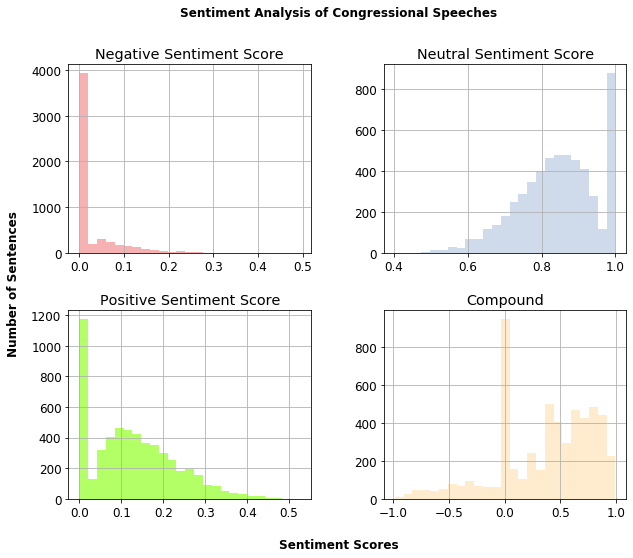

In [15]:
# all scores in 4 histograms
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# plot all 4 histograms
congress_114_bills_df.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')

congress_114_bills_df.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')

congress_114_bills_df.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')

congress_114_bills_df.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
axes[1,1].set_title('Compound')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Sentences', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of Congressional Speeches\n\n', fontsize=12, fontweight='bold');

For each bill mention,  three possible  classes are available. The classes are: 1)  Negative:  When  the compound value is less than or equal to -0.05, 2) Positive review: When the compound value is larger than or equal to 0.05, and 3) Neutral review: When the compound value is between -0.05 and 0.05. These are the boundaries for sentiment classes as  suggested by  the creators of vaderSentiment  (Hutto and Gilbert 2014b). 

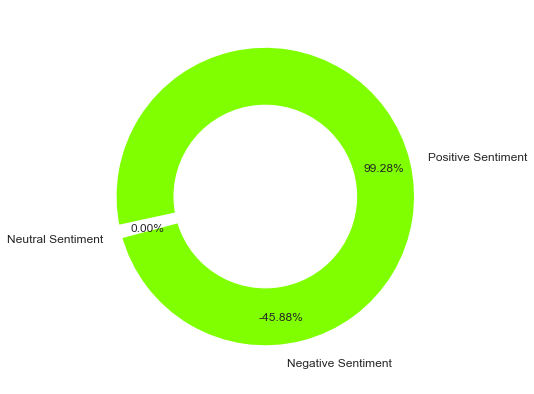

In [26]:
percentiles = congress_114_bills_df.sentiment_compound.describe(percentiles=[.05, .1, .2, .3, .4, .5, .6, .7, .8, .9])

# assign the data
neg = percentiles['5%']
mid = percentiles['20%']
pos = percentiles['max']
names = ['Negative Sentiment', 'Neutral Sentiment','Positive Sentiment']
size = [neg, mid, pos]

# call a pie chart
plt.pie(size, labels=names, colors=['lightcoral', 'lightsteelblue', 'chartreuse'], 
        autopct='%.2f%%', pctdistance=0.8,
        wedgeprops={'linewidth':7, 'edgecolor':'white' })

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.show()

In [18]:
percentiles

count    5502.000000
mean        0.363073
std         0.421223
min        -0.986400
5%         -0.458800
10%        -0.153100
20%         0.000000
30%         0.077200
40%         0.322560
50%         0.436050
60%         0.557400
70%         0.660260
80%         0.765000
90%         0.855430
max         0.992800
Name: sentiment_compound, dtype: float64

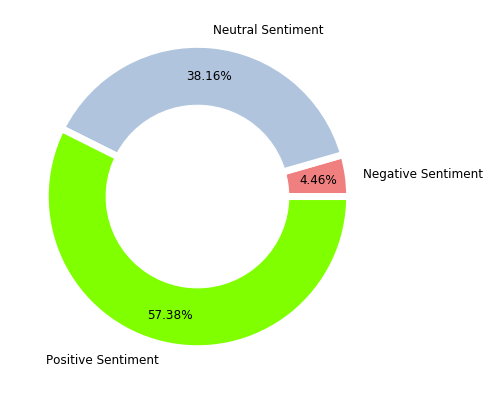

In [19]:
# assign the data
neg = percentiles['30%']
mid = percentiles['70%']
pos = percentiles['max']
names = ['Negative Sentiment', 'Neutral Sentiment','Positive Sentiment']
size = [neg, mid, pos]

# call a pie chart
plt.pie(size, labels=names, colors=['lightcoral', 'lightsteelblue', 'chartreuse'], 
        autopct='%.2f%%', pctdistance=0.8,
        wedgeprops={'linewidth':7, 'edgecolor':'white' })

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.show()

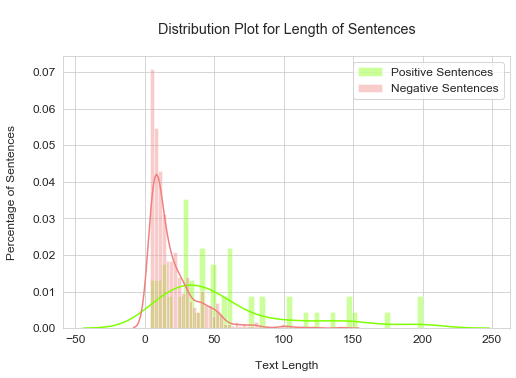

In [27]:
# full dataframe with POSITIVE comments
df_pos = congress_114_bills_df.loc[congress_114_bills_df.sentiment_compound >= 0.95]

# only corpus of POSITIVE comments
pos_comments = df_pos['sentence'].tolist()

# full dataframe with NEGATIVE comments
df_neg = congress_114_bills_df.loc[congress_114_bills_df.sentiment_compound < 0.0]

# only corpus of NEGATIVE comments
neg_comments = df_neg['sentence'].tolist()

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df_pos['sentence_len'], kde=True, bins=50, color='chartreuse')
sns.distplot(df_neg['sentence_len'], kde=True, bins=50, color='lightcoral')

plt.title('\nDistribution Plot for Length of Sentences\n')
plt.legend(['Positive Sentences', 'Negative Sentences'])
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Sentences\n');

In [21]:
# read some positive comments
pos_comments[10:15]

["and finally, i would like to speak in support of chairman smith's legislation, h.r.1150, the frank r. wolf international religious freedom act of 2015. i am a cosponsor of this legislation and i am proud to support international religious freedom.",
 'on the legislative front, last month the house approved h.r.4939, the united states caribbean strategic engagement act of 2016. this act is designed to increase engagement with the caribbean that requires the secretary of state to submit a multiyear plan to congress for u.s. engagement with the caribbean regions and update on its u.s. diplomatic effort to engage the eastern caribbean countries.',
 "thanks to your staff as well for working with my staff and mr. deutch's office to bring up h.r.907, the united states jordan defense cooperation act of 2015. ted could not be present because he has a markup at judiciary, but he wanted me to express, on his behalf, his strong support for this legislation and his gratitude to the full committee

In [22]:
# read some negative comments
neg_comments[10:15]

['in addition to these land management policies, congress also should pass h.r.1009, the wildfire prevention act of 2015, which would permit recipients of fire management assistance grants to use up to 15 percent of the grant amount for post wildland fire mitigation projects to prevent flooding, landslides, and other dangerous conditions caused by wildland fires.',
 'question 8. the approach taken by h.r.2647 to fix fire borrowing would allow the secretaries of agriculture and interior to access the disaster relief fund under fema and allow the worst wildfires to be treated like other natural disasters.',
 "2647 eliminates the need to transfer funds from non fire programs when available suppression funds are exhausted, the requirement in h.r.2647 to fully fund the rolling 10 year average for wildland fire suppression would mean that significantly less funding is available each year in the agency's budget for other important programs, as the rolling 10 year average continues to grow whi